## Bayesian function optimisation 

In [7]:
from math import sin
from math import cos
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot

### The objective function

This function generates the objective function that we don't know and we want to know the maximum of that function in the range 0 to 1. This is a simple function with 5 peeks and we only have one dimension

In [8]:
# the unknown objective function where we want to know the maximum value between 0 and 1
def objective(x, noise=0.1):
    noise = normal(loc=0, scale=noise)
    return (x**2 * cos(6 * pi * x)**12.0) + noise

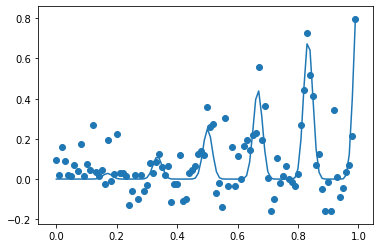

In [9]:
# we can plot this function with and without noise ...
X = arange(0, 1, 0.01)
 
# sample the domain without noise
y = [objective(x, 0) for x in X]
 
# sample the domain with noise
ynoise = [objective(x) for x in X]

# plot the points with noise
pyplot.scatter(X, ynoise)

# plot the points without noise
pyplot.plot(X, y)
# show the plot
pyplot.show()

### The surrogate function

We need to specify the surrogate function. For this we will use the gaussian process algorithm and we threat the problem as a regression problem

In [10]:
# surrogate or approximation for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    with catch_warnings():
        # ignore generated warnings
        simplefilter("ignore")
        prediction = model.predict(X, return_std=True)
        return prediction 

# plot real observations vs surrogate function
def plot(X, y, model):
    # scatter plot of inputs and real objective function
    pyplot.scatter(X, y)
    
    # line plot of surrogate function across domain
    Xsamples = asarray(arange(0, 1, 0.001))
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    
    # The surrogate returns a prediction and a standard deviation for each point
    ysamples, std = surrogate(model, Xsamples)
    
    # We only plot the prediction values
    pyplot.plot(Xsamples, ysamples)
    
    # show the plot
    pyplot.show()

In [11]:
# we take 10 random values
X = random(10)
print('10 random values for X :')
print(X)

10 random values for X :
[0.66612502 0.80710338 0.05264232 0.69110573 0.6545955  0.37860237
 0.66280917 0.09519841 0.9073387  0.8109561 ]


In [12]:
# we generate 10 y values by using the objective function (the function with noise)
y = asarray([objective(x) for x in X])
print('10 generated values for Y with the objective function with extra noise:')
print(y)

10 generated values for Y with the objective function :
[ 0.63991744  0.11909587 -0.02147565  0.2107197   0.40697611  0.18079028
  0.55677467 -0.02579045 -0.01050622  0.08870031]


In [13]:
# we reshape X and Y
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)

In [14]:
print(X)

[[0.66612502]
 [0.80710338]
 [0.05264232]
 [0.69110573]
 [0.6545955 ]
 [0.37860237]
 [0.66280917]
 [0.09519841]
 [0.9073387 ]
 [0.8109561 ]]


In [15]:
print(y)

[[ 0.63991744]
 [ 0.11909587]
 [-0.02147565]
 [ 0.2107197 ]
 [ 0.40697611]
 [ 0.18079028]
 [ 0.55677467]
 [-0.02579045]
 [-0.01050622]
 [ 0.08870031]]


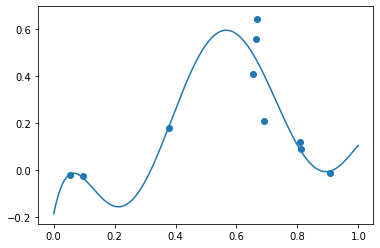

In [16]:
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot the surrogate function that is based on the 10 
plot(X, y, model)

### The acquisition function

In [11]:
# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
    
    # calculate the best surrogate score found so far
    yhat, std = surrogate(model, X)
    
    print('Surrogate called for our data points...')
    print(f'X -> {X}')
    print(f'yhat -> {yhat}')
    
    print('-------------------------------------------------------------')
    best = max(yhat)
    print(f'Max prediction value is {best}')
    
    print('-------------------------------------------------------------')
    
    print('Now we are calling the surrogate function with our random values')
    
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
    
    mu = mu[:, 0]
    print('Predictions for our random values')
    print(mu)
    
    print('-------------------------------------------------------------')
    
    # calculate the probability of improvement for each prediction
    probs = norm.cdf((mu - best) / (std+1E-9))
    
    print('Calculating the probability of improvement')
    print(probs)
    
    return probs
 
# optimize the acquisition function
def opt_acquisition(X, y, model):
    print('Starting the optimisation for the acquisition for X')
    print(X)
    
    print('-------------------------------------------------------------')
    
    # random search, generate random samples (we can do this more optimal, but for now let's do random sampling)
    Xsamples = random(50)
    
    print('Generated 50 random samples ..')
    print(Xsamples)
    
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    
    print('-------------------------------------------------------------')
    
    # calculate the acquisition function for each sample
    scores = acquisition(X, Xsamples, model)
    
    print('The aquisition score for each sample point')
    print(scores)
    
    print('-------------------------------------------------------------')
    
    # locate the index of the largest scores (argmax returns index of largest value)
    ix = argmax(scores)
    
    print('The index with the largest score')
    print(ix)
    
    
    return Xsamples[ix, 0]

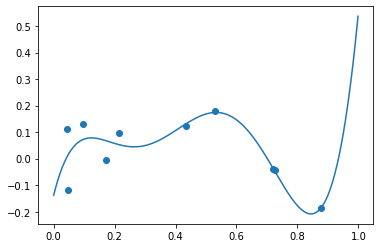

Starting the optimisation for the acquisition for X
[[0.52944329]
 [0.09497217]
 [0.04832441]
 [0.1701596 ]
 [0.71894594]
 [0.72515583]
 [0.21454034]
 [0.04358543]
 [0.43384851]
 [0.87732235]]
-------------------------------------------------------------
Generated 50 random samples ..
[0.0372491  0.80175169 0.71628145 0.71476753 0.3122789  0.45810861
 0.25227703 0.20177523 0.36348108 0.41669132 0.01128    0.38764711
 0.54132587 0.30595339 0.44143457 0.10304983 0.50283564 0.57568246
 0.35931336 0.4932208  0.1106912  0.52515625 0.53844756 0.96284767
 0.06790776 0.46579541 0.85199896 0.5896094  0.5147651  0.16418146
 0.66799404 0.69990784 0.13011446 0.23857891 0.46520924 0.36681439
 0.34030781 0.86794523 0.6723247  0.69367987 0.16145217 0.15793635
 0.89959256 0.61087406 0.21810289 0.27639502 0.9083706  0.91539299
 0.98670252 0.62017272]
-------------------------------------------------------------
Surrogate called for our data points...
X -> [[0.52944329]
 [0.09497217]
 [0.04832441]
 [0.1

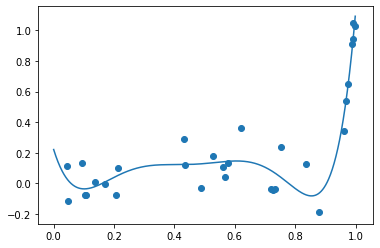

Best Result: x=0.991, y=1.050


In [12]:
# plot real observations vs surrogate function
def plot(X, y, model):
    # scatter plot of inputs and real objective function
    pyplot.scatter(X, y)
    # line plot of surrogate function across domain
    Xsamples = asarray(arange(0, 1, 0.001))
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    ysamples, std = surrogate(model, Xsamples)
    pyplot.plot(Xsamples, ysamples)
    # show the plot
    pyplot.show()
 
# sample the domain sparsely with noise
X = random(10)
y = asarray([objective(x) for x in X])


# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)

# define the model
model = GaussianProcessRegressor()

# fit the model
model.fit(X, y)

# plot before hand
plot(X, y, model)


# perform the optimization process
for i in range(20):
    # select the next point to sample
    x = opt_acquisition(X, y, model)
    
    print('-------------------------------------------------------------')
    print(f'We have selected point {x} for evaluation with our objective function so that we can add it to our belief')
    
    # sample the point
    actual = objective(x)
    print(f'The actual return for {x} is {actual}')
    print('-------------------------------------------------------------')
    
    # summarize the finding by calling the current surrogate function with x
    est, std = surrogate(model, [[x]])
    
    print('x=%.3f, surrogate prediction for x=%3f, actual return from objective function=%.3f' % (x, est, actual))
    
    # add the data to the dataset
    X = vstack((X, [[x]]))
    y = vstack((y, [[actual]]))
    
    # update the model
    model.fit(X, y)
    
    print('Updated our beliefs by training the gaussian process with our previous data and the new sample')
    print('-------------------------------------------------------------')
 
# plot all samples and the final surrogate function
plot(X, y, model)

# best result
ix = argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))